In [1]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


In [2]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)

from kooplearn.datasets.stochastic import LangevinTripleWell1D


In [3]:
langevin = LangevinTripleWell1D(rng_seed=0,gamma=2.0,dt=1e-4)

In [4]:
sample = langevin.sample(0, 1_000_000)

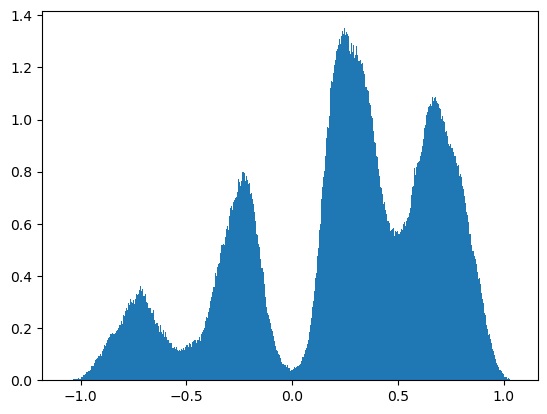

In [5]:
plt.hist(sample, bins=500, density=True);

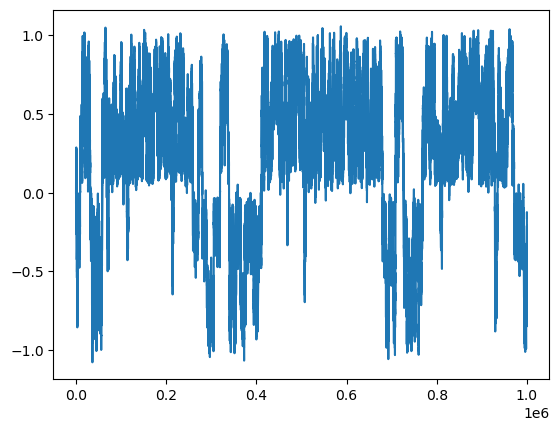

In [6]:
plt.plot(sample)


In [32]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data import traj_to_contexts
#7e-1,0.175 r=10, rrr
kernel = RBF(length_scale=0.175) #0.3
model = kooplearn.models.kernel.KernelGenerator(kernel, reduced_rank=False, rank=2000
                                   
                                   , tikhonov_reg=1e-4
                        )

In [33]:
test=sample[:2_000_000:500]
train_data = traj_to_contexts(test)
forces = langevin.force_fn(test)
forces_train = traj_to_contexts(forces)
train_data.shape


(2000, 2, 1)

In [34]:
model = model.fit(train_data,forces=forces_train/2.0,friction=2/2.0) #np.sqrt(2))


Fitted KernelGenerator model. Lookback length set to 1


In [35]:
vals_gen,vecs_gen = model.eig(eval_right_on=train_data[:,:1, ...])
vecs_gen = vecs_gen.real

/home/tdevergne@iit.local/Documents/kooplearn/kooplearn/_src/operator_regression/dual.py:402: RuntimeWarning: divide by zero encountered in reciprocal
  r_normr = np.where(norm_r == 0.0, 0.0, norm_r**-1)
/home/tdevergne@iit.local/Documents/kooplearn/kooplearn/_src/operator_regression/dual.py:407: RuntimeWarning: invalid value encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


In [36]:
for eval in vals_gen:
    print(eval)

(-8502.368114441932+0j)
(-8333.637675151169+0j)
(-7340.228567915325+0j)
(-7126.6051492677125+0j)
(-6573.334024035043+0j)
(-5549.669673480759-90.31916730403128j)
(-5549.669673480759+90.31916730403128j)
(-4879.898693381732+0j)
(-3725.578125133418+0j)
(-2954.2031843907957+0j)
(-2751.7802547284805+0j)
(-2162.8851818535745+0j)
(-1836.3314979967338+0j)
(-1686.9405331661133+0j)
(-811.0708229719855+0j)
(-348.80422251005643-15.863333954049256j)
(-348.80422251005643+15.863333954049256j)
(-202.44045298658335+0j)
(-88.69792173032761+0j)
(-50.28498515145088-13.946695227462722j)
(-50.28498515145088+13.946695227462722j)
(-9.404826947444347+0j)
(-3.8060933772871026-1.306806230167106j)
(-3.8060933772871026+1.306806230167106j)
(-0.5978686911207429+0j)
(-0.06249964318371552-0.05145258097088975j)
(-0.06249964318371552+0.05145258097088975j)
(-0.06093336986672354+0j)
(-0.005062563434234964+0j)
(-0.0036060682122331543+0j)
(-0.000458972478912029+0j)
(-0.0002643651387699016+0j)
(-3.331423470382395e-05+0j)
(-1.

In [43]:
for eval in vals_gen:
    print(np.exp(eval*0.1))

0j
0j
(1.65166e-319+0j)
(3.1294707518305e-310+0j)
(3.3398777108244856e-286+0j)
(-8.84086201578572e-242-3.6636845523764703e-242j)
(-8.84086201578572e-242+3.6636845523764703e-242j)
(1.1713657509796629e-212+0j)
(1.585615328227893e-162+0j)
(5.018637874545023e-129+0j)
(3.102430034266282e-120+0j)
(1.1670515857825023e-94+0j)
(1.7747465781307293e-80+0j)
(5.458879587516298e-74+0j)
(5.965429465856453e-36+0j)
(-1.1040193878762372e-17-7.105140468965254e-16j)
(-1.1040193878762372e-17+7.105140468965254e-16j)
(1.6148152248767688e-09+0j)
(0.00014057179924957717+0j)
(0.0011474363958314635-0.006447326692168182j)
(0.0011474363958314635+0.006447326692168182j)
(0.3904393268550557+0j)
(0.6776173947857477-0.08905900761765015j)
(0.6776173947857477+0.08905900761765015j)
(0.9419652740867493+0j)
(0.9937563717430757-0.005113178139873254j)
(0.9937563717430757+0.005113178139873254j)
(0.993925189742177+0j)
(0.9994938717826967+0j)
(0.9996394581896018+0j)
(0.9999541038053714+0j)
(0.9999735638355646+0j)
(0.999996668582

In [44]:
from kooplearn._src.operator_regression import dual

def compute_prediction(index,train_data, t, bin_edge1, bin_edge2):
    evs, ul, ur = dual.estimator_eig(
            model.U, model.V, model.kernel_X, model.kernel_YX
    )
    n = model.kernel_YX.shape[0]

        #uv_t = (self.U@ur).T

    h = model.kernel_YX[index]

    interval = np.where(np.logical_and(train_data > bin_edge1, train_data < bin_edge2), 1 ,0)
    s_identity = interval[:,0] / np.sqrt(n)
    print(s_identity.shape)
    g = (model.V@ul).T @ s_identity
    print(ul.shape)
    #print(np.exp(evs*t))
    print(evs.shape)
    print(h.shape)
    pred = ((np.exp(evs*t) * (g[:,0]*h)).sum(axis=-1))
    print(np.exp(evs*t))
    print((np.exp(evs*t) * (g*h)).shape)
    return pred
print(compute_prediction(1000,train_data,0.1,-0.6,-0.5))

/home/tdevergne@iit.local/Documents/kooplearn/kooplearn/_src/operator_regression/dual.py:402: RuntimeWarning: divide by zero encountered in reciprocal
  r_normr = np.where(norm_r == 0.0, 0.0, norm_r**-1)
/home/tdevergne@iit.local/Documents/kooplearn/kooplearn/_src/operator_regression/dual.py:407: RuntimeWarning: invalid value encountered in reciprocal
  r_norm_l = np.where(np.abs(norm_l) == 0, 0.0, norm_l**-1)


(2000, 1)
(2000, 2000)
(2000,)
(2000,)
[0.00000e+000+0.0000000e+00j 0.00000e+000+0.0000000e+00j
 1.65166e-319+0.0000000e+00j ... 1.00000e+000+0.0000000e+00j
 1.00000e+000-2.0514428e-11j 1.00000e+000+2.0514428e-11j]
(2000, 2000)
(355784.7004501991-92.08048950768276j)


In [38]:
print(evs[])

SyntaxError: invalid syntax (3592919154.py, line 1)

In [ ]:
model.V.shape

(2000, 1999)

In [ ]:
from sklearn.metrics import mean_squared_error

def prediction_error(model, contexts):
    init_frames = contexts[:, :model.lookback_len, ...] # Everything in the lookback window is used for inference
    pred_frames = model.predict(init_frames) # Predicting the future frames
    true_frames = contexts[:, model.lookback_len:, ...].reshape(*pred_frames.shape) # The true frames are everything after the lookback length (i.e. the lookforward window)
    
    return mean_squared_error(true_frames, pred_frames)
prediction_error(model,train_data)

0.029432491839358164

###### 

In [ ]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt




solutions =np.load("/home/tdevergne@iit.local/Documents/eigenfunctions.np",allow_pickle=True)
x_values  =np.load("/home/tdevergne@iit.local/Documents/centers.np",allow_pickle=True)
plt.scatter(np.squeeze(train_data[:,:1, ...]),vecs_gen[:,23],label="PCR generator first eigenfunction")
#plt.scatter(np.squeeze(train_data[:,:1, ...]), vecs[:,-2],label="PCR transfer first eigenfunction")
#plt.plot(decomp.x[values],-funcs[values,2],label="exact eigenfunction",color="r")

plt.plot()
num = 3
fig, axes = plt.subplots(num, num, figsize=(20, 20))
#values = np.where(np.logical_and(decomp.x>-1,decomp.x<1))[0]
print(np.where(vecs_gen[:,-1]==0))

new_0 = -(vecs_gen[:,-1]-vecs_gen[:,-1].min())/(vecs_gen[:,-1].min()-vecs_gen[:,-1].max())

for i in range(1,4):
    vecs_gen[:,-i-1] /= vecs_gen[:,-1]
    #vecs_gen[:,-i-1] /= vecs_gen[:,-1]
    new_gen = (vecs_gen[:,-i-1]-vecs_gen[:,-i-1].min())/(vecs_gen[:,-i-1].min()-vecs_gen[:,-i-1].max())
    new_sol = (solutions[:,i]-solutions[:,i].min())/(solutions[:,i].min()-solutions[:,i].max())
    if i ==1 :
        axes[i//num, i%num].scatter(np.squeeze(train_data[:,:1, ...]), -new_gen-1, marker="+", color='r',label="generator PCR EF")

    else:
        axes[i//num, i%num].scatter(np.squeeze(train_data[:,:1, ...]), new_gen, marker="+", color='r',label="generator PCR EF")
    axes[i//num, i%num].scatter(x_values,new_sol, marker="+", color='k', label="generator exact EF")
    
    axes[i//num, i%num].grid(True, linestyle='--', alpha=.5)
    axes[i//num, i%num].set_xlim(-1, 1)
    #axes[i//num, i%num].set_ylim(y_min, y_max)

    axes[i//num, i%num].legend()

plt.xlabel('x')
#plt.ylabel('')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/tdevergne@iit.local/Documents/eigenfunctions.np'

In [ ]:
plt.plot(decomp.x,funcs[:,1],label="exact eigenfunction",color="r")

NameError: name 'decomp' is not defined

In [ ]:
np.real(vecs_gen[:,-i-1]/vecs_gen[:,-1])

array([-0.34645806, -0.22810225,  0.26729326, ..., -1.28460193,
       -0.6005113 , -1.03022335])

In [ ]:
vecs_gen[:,-2]

array([0.72259119+0.69127562j, 0.72267646+0.69118647j,
       0.72302753+0.69081922j, ..., 0.72239467+0.69148098j,
       0.72216378+0.69172211j, 0.72216693+0.69171882j])